# Esame COVID Erik Moro

Importo le librerie necessarie per realizzare il programma, ovvero numpy, matplotlib e pandas

In [326]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import poisson
import emcee
from scipy.optimize import minimize

# Parte 1

Dopo aver scaricato il file contenete i valori covid e rinominato per comodità personale covid.csv, attraverso la libreria
pandas lo leggo e lo trasformo in un dataframe

In [327]:
dati = pd.read_csv('covid.csv', delimiter=',')

Seleziono solamente le righe contenenti i dati della regione interessata, ovvero in questo caso il Friuli Venezia Giulia e creo
una tabella con solo quei dati e la chiamo dati1 e definisco la variabile stringa con il valore che mi interssa
analizzare, qui la consegna chiedeva di analizzare i nuovi positivi.

In [328]:
regione=str('Friuli Venezia Giulia')
var=str('nuovi_positivi')
dati1=dati[dati['denominazione_regione']==regione]
dati1.reset_index(drop=True)

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
0,2020-02-24T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,2023-10-28T17:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,118,2,120,783,...,NaN,0.0,NaN,NaN,241031.0,347624.0,3879223.0,3945443.0,ITH,ITH4
1343,2023-10-29T17:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,117,2,119,723,...,NaN,0.0,NaN,NaN,241036.0,347682.0,3879285.0,3945676.0,ITH,ITH4
1344,2023-10-30T17:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,120,4,124,672,...,NaN,2.0,NaN,NaN,241039.0,347720.0,3879301.0,3945819.0,ITH,ITH4
1345,2023-10-31T17:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,110,2,112,702,...,Il totale del caso positivi è stato ridotto di...,1.0,NaN,NaN,241054.0,347837.0,3879484.0,3946404.0,ITH,ITH4


Costruisco un set di valori, dove per le x rappresentantano i giorni passati da quando ho cominciato
a raccogliere dati. Costruisco una lista di numeri dall'1 al numero di giorni presenti nel dataframe,
mentre per le y estrapolo dal dataframe con solo i valori del Friuli Venezia Giulia solamente la colonna
dei nuovi positivi

In [329]:
x=[i for i in range(len(dati1))]
y=dati1[var]

Grafico dunque l'andamento di y in funzione di x grazie alle funzioni di matplotlib. I picchi che noto nel grafico saranno i massimi delle varie ondate di contagi

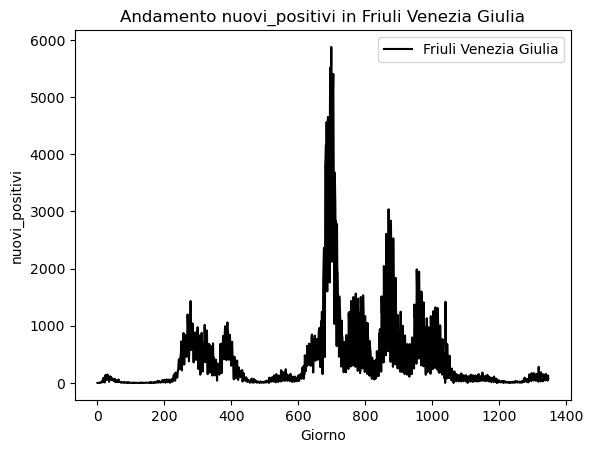

In [330]:
plt.plot(x,y, color='black', label=regione)
plt.title("Andamento {} in {}".format(var,regione) )
plt.ylabel(var)
plt.xlabel('Giorno')
plt.legend()
plt.show()

# Parte 2

Definisco le due funzioni date per descrivere l'andamento dei contagi, ovvero la funzione logistica (ottima per modellare la crescita di contagi) e la funzione di Gompertz ( ottima soprattutto per modellarne da decrescita)

In [331]:
def logistica1(Ntot,k,t0,t):
    logi=Ntot/(1+np.exp(-k*(t-t0)))
    return logi

In [332]:
def logistica(Ntot,k,t0,t):
    logi=[Ntot/(1+np.exp(-k*(t-t0))) for t in t]
    return logi

In [333]:
def gompertz1(Ntot,k,t0,t):
    gomp=Ntot*np.exp(-np.log(Ntot)*np.exp(-k*(t-t0)))
    return gomp

In [334]:
def gompertz(Ntot,k,t0,t):
    gomp=[Ntot*np.exp(-np.log(Ntot)*np.exp(-k*(t-t0))) for t in t]
    return gomp

Ne osservo gli andamenti in base ai parametri inseriti

In [335]:
k=0.07
Ntot=1000.
t0=0.
t02=130.


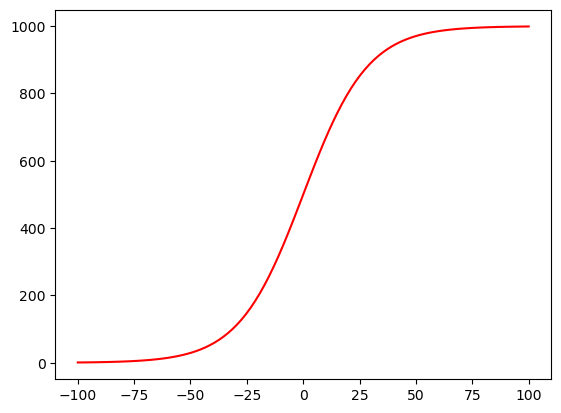

In [336]:
t=np.linspace(-100,100,100)

logi= logistica(Ntot,k,t0,t)

plt.plot(t, logi, color='red')
plt.show()

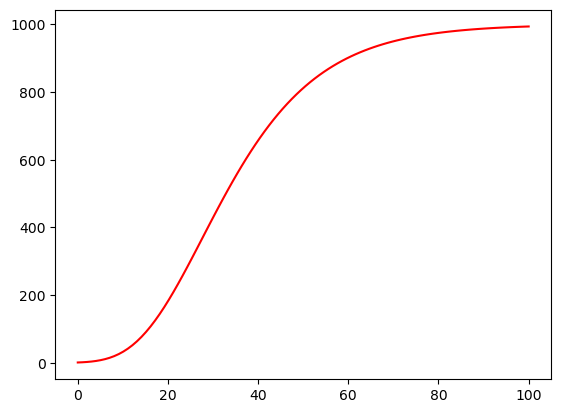

In [337]:
t=np.linspace(0,100,100)

gomp= gompertz(Ntot,k,t0,t)

plt.plot(t, gomp, color='red')
plt.show()

Costruisco le due funzioni che mi danno la possibilità di calcolare la differenza tra due giorni consecutivi, sia per la funzione logistica che quella di gompertz. Ho quindi definito la funzione che calcola, ad esempio, il valore della logistica al giorno i+1 e sottratto poi quella al giorno i. Analogamente faccio per la funzione di Gompertz

In [357]:
def ndifflogi(Ntot,k,t0,t):
    logi1=logistica(Ntot,k,t0,t+1)
    logi2=logistica(Ntot,k,t0,t)
    logi=[elm1-elm2 for elm1,elm2 in zip(logi1,logi2)]
    return logi

In [362]:
def ndiffgomp(Ntot,k,t0,t):
    gomp1=gompertz(Ntot,k,t0,t+1)
    gomp2=gompertz(Ntot,k,t0,t)
    gomp=[elm1-elm2 for elm1,elm2 in zip(gomp1,gomp2)]
    return gomp

Ora grazie alle 2 nuove funzioni che ho definito precedentemente ne faccio i grafici per vedere che andamenti hanno

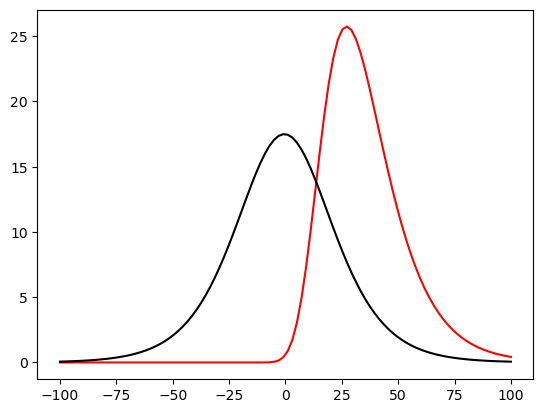

In [363]:
t=np.linspace(-100,100,100)

gomp= ndiffgomp(Ntot,k,t0,t)
logi= ndifflogi(Ntot,k,t0,t)

plt.plot(t, gomp, color='red')
plt.plot(t, logi, color='black')
plt.show()



# Parte 3

Per questa parte seleziono l'intervallo richiesto della prima ondata, ovvero, l'intervallo che va dal 30 Marzo 2020 e lungo 35 giorni e lo grafico per vederne fisicamente l'andamento. Il numero di nuovi positivi giornalieri è stato trovato selezionando i giorni interessati dalla lista y comprensiva di tutti i giorni

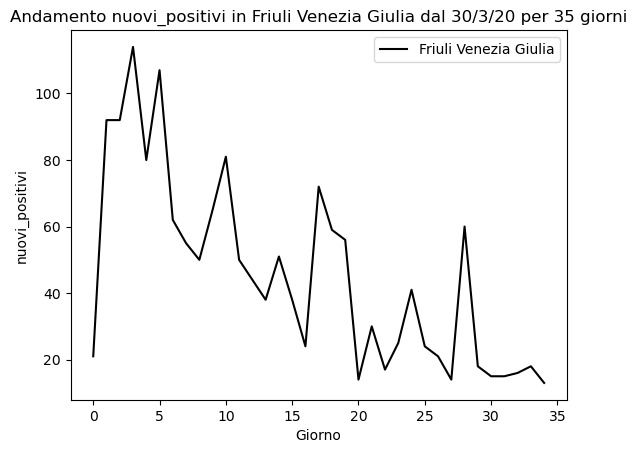

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
5,2020-02-24T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2020-02-25T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,2020-02-26T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,2020-02-27T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,2020-02-28T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,2020-02-29T17:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,2020-03-01T17:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,2020-03-02T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,2020-03-03T18:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,1,0,1,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,2020-03-04T17:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,3,0,3,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [364]:
posizione1=(dati1.index[dati1['data'] == '2020-03-30T17:00:00'].tolist())
pos1=int((posizione1[0]-5)/21)

dati36=dati1.head(36)

x35=[i for i in range(35)]
y35=y[pos1:pos1+35]

dati35=np.array([x35,y35])


plt.plot(x35,y35, color='black', label=regione)
plt.title("Andamento {} in {} dal 30/3/20 per 35 giorni".format(var,regione) )
plt.ylabel(var)
plt.xlabel('Giorno')
plt.legend()
plt.show()

dati36

La consegna richiede la realizzazione poissoniana, dunque scrivo la funzione di likelihood come:
$$
L = \prod_{i} \left( \frac{\nu_i^{n_i} \cdot e^{-\nu_i}}{n_i!} \right)
$$
Dove $\nu_i$ rappresenta il valor medio calcolato attraverso la funzione logistica o di Gompertz. Per comodità la funzione la modifico in modo da calcolarne il logaritmo, facendo così al posto di una produttoria potrò lavorare con una sommatoria.

In [365]:
def log_likelihood(theta, y35):
    Ntot, k, t0 = theta
    x35=[i for i in range(35)]
    nu=ndifflogi(Ntot,k,t0,x35)
    return np.sum(y35*np.log(nu)-nu)

Ora definisco un prior e posso dunque calcolare la posterior come 

In [366]:
def log_prior(theta):
    Ntot, k, t0 = theta
    if Ntot and t0 >=0:
        return 0.0
    else:
        return -np.inf
    
def log_posterior(theta,y35):
    logprior=log_prior(theta)
    if np.isfinite(logprior):
        return logprior + log_likelihood(theta, y35)
    else:
        return -np.inf

In [367]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_posterior(*args)
initial = np.array([1000, 0.1,6])
soln = minimize(nll, initial, args=(dati36))
Ntotbf,kbf,t0bf = soln.x
print(soln.x)

TypeError: can only concatenate list (not "int") to list

In [ ]:
pos = soln.x *(1+ 1e-6 * np.random.randn(32, 2))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(...)
)
sampler.run_mcmc(pos, 1000, progress=True);

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$N_{tot}$", "$k$","t_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=300, flat=True)
print(flat_samples.shape)

# Parte 4

In [ ]:
posizione1=(dati1.index[dati1['data'] == '2020-06-03T17:00:00'].tolist())
posizione2=(dati1.index[dati1['data'] == '2021-06-03T17:00:00'].tolist())
pos1=int((posizione1[0]-5)/21)
pos2=int((posizione2[0]-5)/21)
x35=[i for i in range(365)]
y35=y[pos1:pos2]

plt.plot(x35,y35, color='black', label=regione)
plt.title("Andamento {} in {} prima ondata".format(var,regione) )
plt.ylabel(var)
plt.xlabel('Giorno')
plt.legend()
plt.show()